### Importing packages

In [1]:
import datetime
import glob
import joblib
import os
import pathlib
import pickle
import subprocess
import yaml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from keras.models import load_model
from PIL import Image
from sklearn import svm, metrics, datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

### Setting parameters from .yaml file

In [2]:
with open('params.yaml') as yaml_data:
    
    params = yaml.safe_load(yaml_data)

TRAINING_CSV_PATH = params[0]['TRAINING_CSV_PATH']
IMAGE_WIDTH = params[1]['IMAGE_WIDTH']
IMAGE_HEIGHT = params[2]['IMAGE_HEIGHT']
N = params[3]['N_sample']
test_sample = params[4]['test_split']
random_state = params[5]['random_state']

# Image reading

In [3]:
def build_images_database(path):
    """Build a pandas DataFrame with all images information.
    
    Parameters
    ----------
    path: path pattern to read csv files containing images information
    
    Returns
    -------
    A pandas DataFrame with one line per image
    """
    df_list = []
    for filename in glob.glob(path):
        df = pd.read_csv(filename, sep=';')
        df['path'] = os.path.dirname(filename) + '/' + df['Filename']
        df_list.append(df)
    
    return pd.concat(df_list, ignore_index=True)


def build_images_list(filename_list, boxes_list=None):
    """Build a list of images as Numpy array
    
    Parameters
    ----------
    filename_list: list of images filenames
    boxes_list: optional list of boxes for clipping within images. Boxes are 4-tuples (x1, y1, x2, y2).
    
    Returns
    -------
    A list of images as Numpy arrays
    
    """
    
    # If no boxes_list is given, generate a fake boxes list with None boxes
    # image.resize will take full size images if argument box == None
    if boxes_list is None:
        boxes_list = [None] * len(filename_list)
        
    assert len(filename_list) == len(boxes_list), "filenames and boxes lists must have the same length"
    
    images_list = []
    for (filename, image_box) in zip(filename_list, boxes_list):
        image = Image.open(filename)
        image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
        image = np.array(image)
        images_list.append(image)
        
    return images_list


def build_classes_array(df, col_name='ClassId'):
    """Build a vector (numpy array) of classes
    
    Parameters
    ----------
    df: pandas DataFrame with a column containing classes id
    
    Returns
    -------
    Numpy array with image classes
    
    """
    return df[col_name].values


In [4]:
images_df = build_images_database(TRAINING_CSV_PATH)
images_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
0,00000_00000.ppm,29,30,5,6,24,25,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
1,00000_00001.ppm,30,30,5,5,25,25,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
2,00000_00002.ppm,30,30,5,5,25,25,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
3,00000_00003.ppm,31,31,5,5,26,26,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
4,00000_00004.ppm,30,32,5,6,25,26,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...


In [5]:
N = 5000
N = None # Take all

if N is None:
  images_list = build_images_list(images_df['path'].values,
                                  images_df.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                        axis=1).values)
  data = np.array(images_list)
  labels = build_classes_array(images_df)
else:
  images_list = build_images_list(images_df.head(N)['path'].values,
                                  images_df.head(N).apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                            axis=1).values)
  data = np.array(images_list)
  labels = build_classes_array(images_df)[:N]

print(data.shape, labels.shape)

(39209, 30, 30, 3) (39209,)


# Model training

### Preparing the data

In [6]:
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_sample, random_state = random_state)

train_size = X_train.shape[0]
test_size = X_test.shape[0]

X_train = X_train.reshape(train_size,-1)
X_test = X_test.reshape(test_size,-1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 2700) (7842, 2700) (31367,) (7842,)


### Model estimation

In [9]:
# now to Now predict the value of the digit on the test data
classifier = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train)

y_pred = classifier.predict(X_test)

metrics.accuracy_score(y_test, y_pred)

0.9702881917878092

### Saving model

In [11]:
def save_classifier(model, basename):
    """Save with joblib to pkl format a SVM model with a timestamp

    Paramaters
    ----------
    model: trained tf model
    basename: basename including path to use for filename

    Returns
    -------
    None
    """
    #joblib.dump(clf, 'D:/0_AMSE/0-AMSE/Mag_3/Big_Data/hands-on-2021/models/'+'{}_{}.pkl'.format(basename, 
                                                                                            #datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))
    #model.save('{}_{}.h5'.format(basename, datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))
    
    filename = '../models/{}_{}.pkl'.format(basename, datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
    pickle.dump(model, open(filename, 'wb'))
    return

In [12]:
save_classifier(classifier, 'traffic_signs')

### Loading and testing model

In [35]:
classifier_load = pickle.load(open('../models/traffic_signs_2021-03-31_13-58-06.pkl', 'rb'))

In [13]:
def classify_image_svm(path, model, image_box=None):
    """Classify image by model

    Parameters
    ----------
    path: filepath to image
    model: tf/keras classifier

    Returns
    -------
    class id with highest probability is returned
    """
    images_list = []
    image = Image.open(path)
    image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
    image = np.array(image)
    images_list.append(image)

    return model.predict(np.array(images_list).reshape(1, -1))

[22]


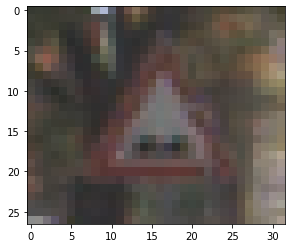

In [37]:
image_sample = images_df.sample(1)


result = classify_image_svm(image_sample['path'].values[0],
               classifier_load,
               image_sample.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                  axis=1).values[0]
               )
print(result)

plt.imshow(Image.open(image_sample['path'].values[0]))

In [38]:
test_images_df = pd.read_csv('../data/raw/GTSRB_Final_Test_GT/GT-final_test.csv', sep=';')
test_images_df['path'] = test_images_df['Filename'].apply(lambda x: '../data/raw/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/' + x)
test_images_df.tail()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
12625,12625.ppm,42,41,5,6,37,36,12,../data/raw/GTSRB_Final_Test_Images/GTSRB/Fina...
12626,12626.ppm,50,51,6,5,45,46,33,../data/raw/GTSRB_Final_Test_Images/GTSRB/Fina...
12627,12627.ppm,29,29,6,6,24,24,6,../data/raw/GTSRB_Final_Test_Images/GTSRB/Fina...
12628,12628.ppm,48,49,5,6,43,44,7,../data/raw/GTSRB_Final_Test_Images/GTSRB/Fina...
12629,12629.ppm,32,31,6,5,27,26,10,../data/raw/GTSRB_Final_Test_Images/GTSRB/Fina...


In [23]:
test_list = build_images_list(test_images_df['path'].values,
                              test_images_df.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                   axis=1).values)
test_data = np.array(test_list)
test_labels = build_classes_array(test_images_df)


In [28]:
test_data_svm = test_data.reshape(test_data.shape[0], -1)

print(test_data_svm.shape, test_data.shape, test_labels.shape)

(12630, 2700) (12630, 30, 30, 3) (12630,)


In [39]:
results = classifier_load.predict(test_data_svm)

In [44]:
print((test_labels == results).sum() / test_labels.shape[0])

accuracy_df = pd.DataFrame()
accuracy_df['actual'] = test_labels
accuracy_df['predicted'] = results

0.8738717339667459


In [53]:
test_data.shape

(12630, 30, 30, 3)

### Loading neural network

In [50]:
load_nn = load_model('../models/traffic_signs_2021-03-19_13-51-00.h5')

In [63]:
results_nn = np.argmax(load_nn.predict(test_data), axis=-1)

In [65]:
accuracy_df['predicted_nn'] = results_nn

### Predicted data VS real data for each model

Text(0.5, 1.0, 'Neural Network')

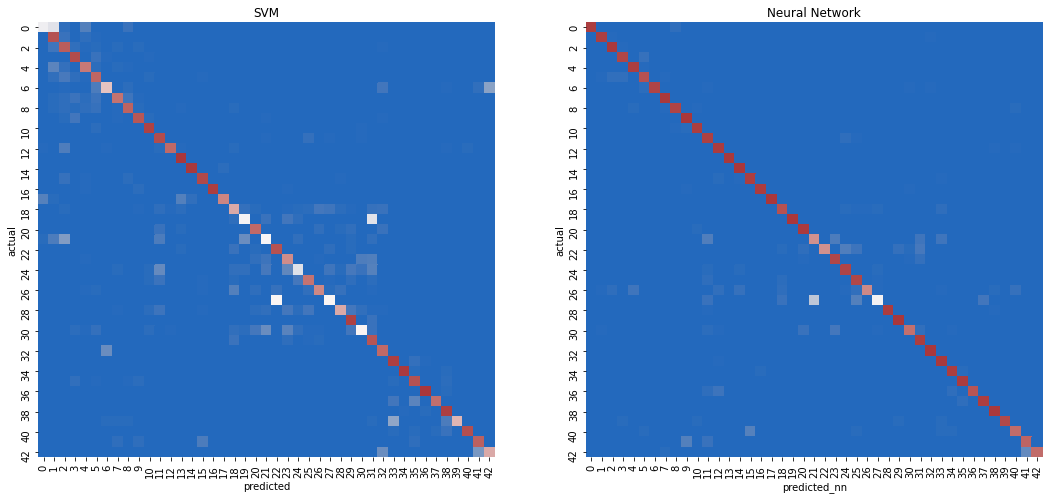

In [76]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 8))
sns.heatmap(pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'], normalize='index'),
            cmap='vlag',
            cbar = False,
            ax=ax1)
ax1.set_title('SVM')
sns.heatmap(pd.crosstab(accuracy_df['actual'], accuracy_df['predicted_nn'], normalize='index'),
            cmap='vlag',
            cbar = False,
            ax=ax2)
ax2.set_title('Neural Network')

Le neural Network donne de meilleurs résultats, malgré quelques erreurs de prédiction. <br>
L'entraînement du SVM a été limité par les temps de calculs, avec plus de tuning 